## Transfer Learning

In [1]:
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as nnF
import torch.optim as optim
from torch.utils.data import DataLoader as torch_dataloader
import torchvision
from torchvision import datasets, transforms
import torchvision.models as tv_models

## Build Dataloaders
Since the images are stored in individual files, we use datasets from torchvision <br>
Since the number of images are relatively small, we need data augmentation - apply different transforms to the images <br>
The dataset is from https://download.pytorch.org/tutorial/hymenoptera_data.zip

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
dataset_train = datasets.ImageFolder('data/train', transform=data_transforms['train'])
dataset_val = datasets.ImageFolder('data/val', transform=data_transforms['val'])
loader_train = torch_dataloader(dataset_train, batch_size=8, shuffle=True, num_workers=0)
loader_val = torch_dataloader(dataset_val, batch_size=8, shuffle=False, num_workers=0) 

In [3]:
len(dataset_train)

244

In [4]:
len(loader_train)

31

In [5]:
len(dataset_val)

153

In [6]:
len(loader_val)

20

In [9]:
(x,label)=dataset_train[0]
print(x.shape)
print(label)

torch.Size([3, 224, 224])
0


In [10]:
(x,label)=dataset_train[200]
print(x.shape)
print(label)

torch.Size([3, 224, 224])
1


Show some images

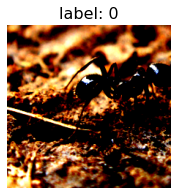

In [11]:
fig, ax = plt.subplots(figsize=(3, 3))
for n in range(0, 10, 1):
    x = dataset_train[n][0].detach().cpu().numpy()
    y = dataset_train[n][1]
    x = x.transpose(1,2,0)
    ax.imshow(x)
    ax.set_title('label: ' + str(y), fontsize=16)
    ax.axis('off')
    display.clear_output(wait=False)
    display.display(fig)
    plt.pause(0.5)  

## Define a CNN based on Resnet50

In [17]:
from torchvision.models import ResNet50_Weights
class Net(nn.Module):
    def __init__(self):
        super().__init__()        
        #use resnet50 as the base model
        #self.resnet50 = tv_models.resnet50(pretrained=True) #old Pytorch
        self.resnet50 = tv_models.resnet50(weights=ResNet50_Weights.DEFAULT)
        #modified the last layer for binary classification  
        self.resnet50.fc=torch.nn.Linear(2048, 1)           
        #freeze all parameters
        for p in self.resnet50.parameters():
            p.requires_grad = False 
        #set the parameters of layer4 to be trainable       
        for p in self.resnet50.layer4.parameters():
            p.requires_grad = True       
        #set the parameters of fc to be trainable       
        for p in self.resnet50.fc.parameters():
            p.requires_grad = True       
        
    def get_trainable_parameters(self):
        pList=list(self.resnet50.layer4.parameters())+list(self.resnet50.fc.parameters())
        return pList
    
    def forward(self,x):
        z = self.resnet50(x)
        z = z.view(-1)
        return z

In [27]:
def save_checkpoint(filename, model, optimizer, result, epoch):
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'result':result},
               filename)
    print('saved:', filename)

In [13]:
tv_models.resnet50(weights=ResNet50_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\Administrator/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100.0%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## The function to train the model in one epoch

In [18]:
def train(model, device, optimizer, dataloader, epoch):    
    model.train()#set model to training mode
    loss_train=0
    acc_train =0 
    for batch_idx, (X, Y) in enumerate(dataloader):
        #print(X.shape, Y.shape)
        #print(X.dtype, Y.dtype)
        Y = Y.to(X.dtype)
        X, Y = X.to(device), Y.to(device)
        Z = model(X)#forward pass
        loss = nnF.binary_cross_entropy_with_logits(Z, Y)
        optimizer.zero_grad()#clear grad of each parameter
        loss.backward()#backward pass
        optimizer.step()#update parameters
        loss_train+=loss.item()        
        Yp = (Z.data > 0).to(torch.int64)
        Y = Y.to(torch.int64)
        acc_train+= torch.sum(Yp==Y).item()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{:.0f}%]\tLoss: {:.6f}'.format(
                    epoch, 100. * batch_idx / len(dataloader), loss.item()))
    loss_train/=len(dataloader)
    acc_train/=len(dataloader.dataset) 
    return loss_train, acc_train

## The Function to test the model
It will calculate average accuracy, sensitivity(recall) and precision from the confusion matrix

In [19]:
def test(model, device, dataloader):
    model.eval()#set model to evaluation mode
    loss_test=0
    acc_test =0
    Confusion=np.zeros((2,2))
    with torch.no_grad(): # tell Pytorch not to build graph in the with section
        for batch_idx, (X, Y) in enumerate(dataloader):     
            Y = Y.to(X.dtype)
            X, Y = X.to(device), Y.to(device)
            Z = model(X)#forward pass            
            loss = nnF.binary_cross_entropy_with_logits(Z, Y)
            loss_test+=loss.item()
            Yp = (Z.data > 0).to(torch.int64)
            Y = Y.to(torch.int64)
            acc_test+= torch.sum(Yp==Y).item()
            for i in range(0, 2):
                for j in range(0, 2):
                    Confusion[i,j]+=torch.sum((Y==i)&(Yp==j)).item()
    loss_test/=len(dataloader)        
    acc_test/=len(dataloader.dataset)
    Sens=np.zeros(2)
    Prec=np.zeros(2)   
    for n in range(0, 2):
        TP=Confusion[n,n]
        FN=np.sum(Confusion[n,:])-TP
        FP=np.sum(Confusion[:,n])-TP
        Sens[n]=TP/(TP+FN)
        Prec[n]=TP/(TP+FP)    
    Acc = Confusion.diagonal().sum()/Confusion.sum() # should be the same as acc_test
    return loss_test, acc_test, (Confusion, Acc, Sens, Prec)

## Create a model, and start the training-validation process
We do not have the testing dataset.

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device', device)
model=Net()
model.to(device)
optimizer = optim.SGD(model.get_trainable_parameters(), lr=0.0001, momentum=0.99) 
#---------------------------------------------------------
(x,label)=dataset_train[0]
x=x.view(1,3,224,224).to(device)
z=model(x)
#
#run this whenever creating a new model
loss_train_list=[]
acc_train_list=[]
loss_val_list=[]
acc_val_list=[]
epoch_save=-1

In [21]:
z

tensor([0.0680], grad_fn=<ViewBackward0>)

In [22]:
y_hat = torch.sigmoid(z)
y_hat

tensor([0.5170], grad_fn=<SigmoidBackward0>)

In [23]:
z.shape

torch.Size([1])

In [29]:
def plot_result(loss_train_list, acc_train_list, 
                loss_val_list, acc_val_list):    
    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    ax[0].set_title('loss v.s. epoch',fontsize=16)
    ax[0].plot(loss_train_list, '-b', label='training loss')
    ax[0].plot(loss_val_list, '-g', label='validation loss')
    ax[0].set_xlabel('epoch',fontsize=16)
    #ax[0].set_xticks(np.arange(len(loss_train_list)))
    ax[0].legend(fontsize=16)
    ax[0].grid(True)
    ax[1].set_title('accuracy v.s. epoch',fontsize=16)
    ax[1].plot(acc_train_list, '-b', label='training accuracy')
    ax[1].plot(acc_val_list, '-g', label='validation accuracy')
    ax[1].set_xlabel('epoch',fontsize=16)
    #ax[1].set_xticks(np.arange(len(loss_train_list)))
    ax[1].legend(fontsize=16)
    ax[1].grid(True)
    return fig, ax

In [25]:
#update learning reate
lr_new=0.0001
for g in optimizer.param_groups:
    g['lr']=lr_new

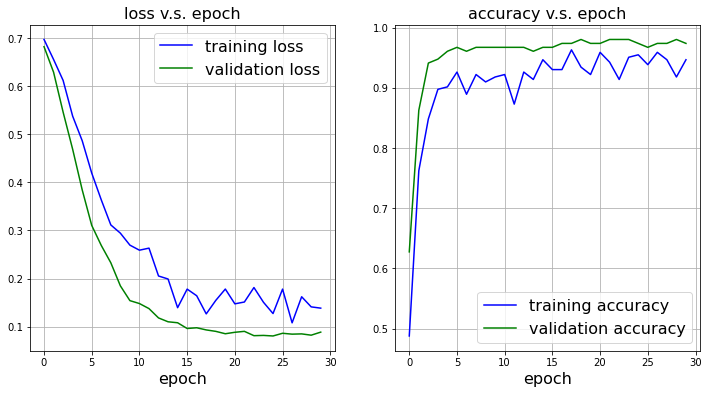

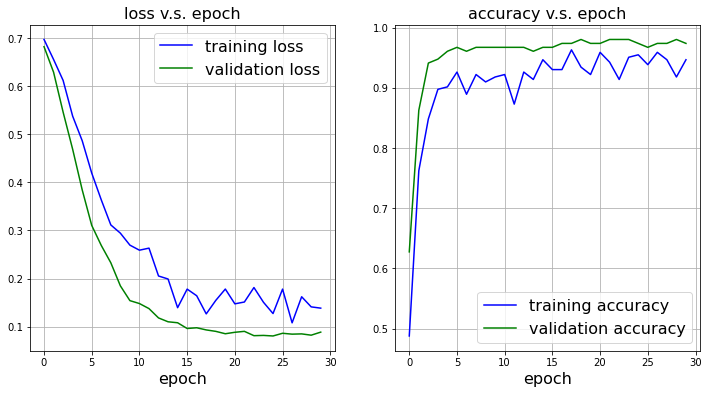

In [30]:
for epoch in range(epoch_save+1, 30):
    t0=time.time()
    #-------- training --------------------------------
    loss_train, acc_train =train(model, device, optimizer, loader_train, epoch)    
    loss_train_list.append(loss_train)
    acc_train_list.append(acc_train)
    print('epoch', epoch, 'training loss:', loss_train, 'acc:', acc_train)
    #-------- validation --------------------------------
    loss_val, acc_val, other_val = test(model, device, loader_val)
    loss_val_list.append(loss_val)
    acc_val_list.append(acc_val)
    print('epoch', epoch, 'validation loss:', loss_val, 'acc:', acc_val)   
    t1=time.time()
    print("time cost", t1-t0)
    #--------save model-------------------------
    result = (loss_train_list, acc_train_list, 
              loss_val_list, acc_val_list, other_val)
    save_checkpoint('CNN_TL_Pytorch_epoch'+str(epoch)+'.pt', model, optimizer, result, epoch)
    epoch_save=epoch
    #------- show result ----------------------
    display.clear_output(wait=False)
    plt.close('all')
    fig, ax = plot_result(loss_train_list, acc_train_list, 
                          loss_val_list, acc_val_list)
    display.display(fig)

(<Figure size 864x432 with 2 Axes>,
 array([<AxesSubplot:title={'center':'loss v.s. epoch'}, xlabel='epoch'>,
        <AxesSubplot:title={'center':'accuracy v.s. epoch'}, xlabel='epoch'>],
       dtype=object))

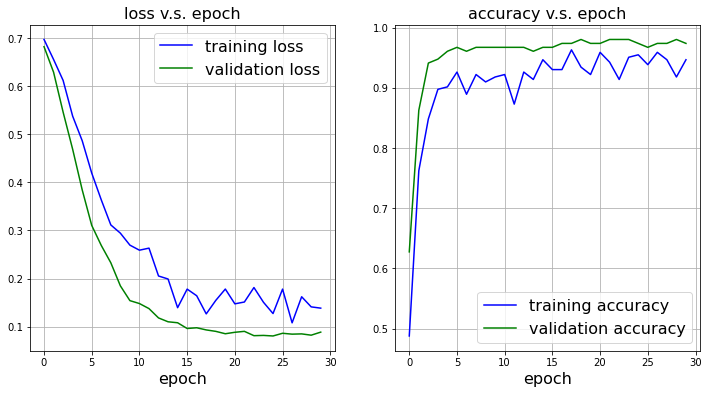

In [31]:
plot_result(loss_train_list, acc_train_list, 
            loss_val_list, acc_val_list)

load the best model

In [32]:
best_id= np.array(acc_val_list).argmax()
best_id

18

In [33]:
epoch_save=best_id
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
checkpoint=torch.load('CNN_TL_Pytorch_epoch'+str(epoch_save)+'.pt', map_location=device)
model=Net()
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval() 
#
optimizer = optim.SGD(model.get_trainable_parameters(), lr=0.0001, momentum=0.99) 
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#
(loss_train_list, acc_train_list, 
 loss_val_list, acc_val_list, other_val) = checkpoint['result']   

In [34]:
loss_val, acc_val, (Confusion, Acc, Sens, Prec) = test(model, device, loader_val)
Confusion_sens=Confusion.copy()
for n in range(0, 2):
    Confusion_sens[n,:]/=np.sum(Confusion[n,:])
Confusion_prec=Confusion.copy()
for n in range(0, 2):
    Confusion_prec[:,n]/=np.sum(Confusion[:,n])
print('Accuracy (average)', acc_val)
print('Accuracy (average)', Acc)
print('Sensitivity', Sens)
print('Precision', Prec)
print('Confusion_sens \n', Confusion_sens)
print('Confusion_prec \n', Confusion_prec)

Accuracy (average) 0.9803921568627451
Accuracy (average) 0.9803921568627451
Sensitivity [0.95714286 1.        ]
Precision [1.         0.96511628]
Confusion_sens 
 [[0.95714286 0.04285714]
 [0.         1.        ]]
Confusion_prec 
 [[1.         0.03488372]
 [0.         0.96511628]]


## Visualize the kernels of the first convolution layer

In [35]:
w=model.resnet50.conv1.weight
w.size()

torch.Size([64, 3, 7, 7])

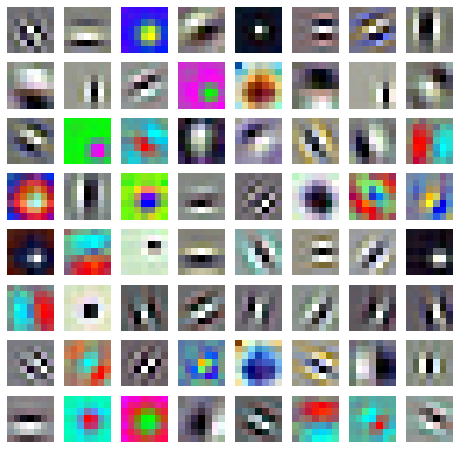

In [36]:
w=model.resnet50.conv1.weight.detach().cpu().numpy()
fig, ax = plt.subplots(8,8, figsize=(8,8))
for i, axi in enumerate(ax.flat):
    I = w[i,:,:,:]
    I = I.transpose(1,2,0)
    I_max = I.max(axis=(0,1), keepdims=True)
    I_min = I.min(axis=(0,1), keepdims=True)    
    I = (I - I_min)/(I_max-I_min)
    axi.imshow(I)
    axi.axis('off')

## Visualize the gradient of loss with respect to input

In [37]:
def normalize_color_image(I):
    I_max = I.max(axis=(0,1), keepdims=True)
    I_min = I.min(axis=(0,1), keepdims=True)    
    I = (I - I_min)/(I_max-I_min)
    return I

Text(0.5, 1.0, 'abs(dL/dx)')

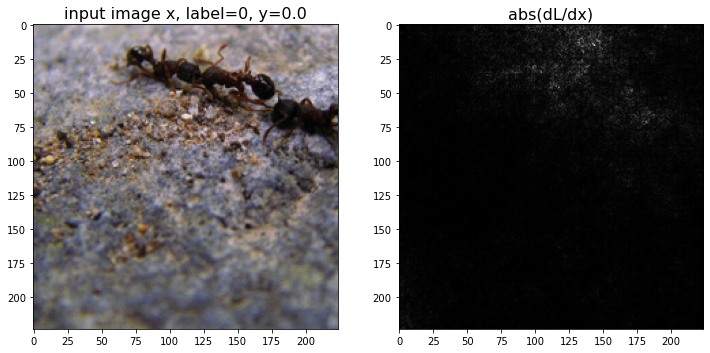

In [38]:
(x,label)=dataset_train[10]
x=x.view(1,3,224,224).to(device)
x.requires_grad=True
z=model(x)
y=torch.tensor([label], dtype=x.dtype, device=device)
loss = nnF.binary_cross_entropy_with_logits(z, y)
loss.backward()
#--------------------------------------------------
y=y.item()
xx = x.detach().cpu().numpy().squeeze()
xx=xx.transpose(1,2,0)
x_grad=x.grad.data.detach().cpu().numpy().squeeze()
x_grad=x_grad.transpose(1,2,0)
x_grad=np.abs(x_grad).sum(axis=2)
xx = normalize_color_image(xx)
#--------------------------------------------------
fig, ax = plt.subplots(1,2, figsize=(12,10))
ax[0].imshow(xx)
ax[0].set_title('input image x, label='+str(label)+', y='+str(y), fontsize=16)
ax[1].imshow(x_grad, cmap='gray', vmin=x_grad.min(), vmax=x_grad.max())
ax[1].set_title('abs(dL/dx)', fontsize=16)

(-0.5, 223.5, 223.5, -0.5)

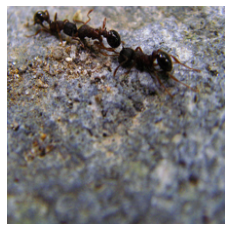

In [39]:
(x,label)=dataset_train[10]
x = x.detach().cpu().numpy().squeeze().transpose(1,2,0)
x = normalize_color_image(x)
fig, ax = plt.subplots()
ax.imshow(x)
ax.axis('off')

In [40]:
x.shape

(224, 224, 3)